In [1]:
!pip install -q flwr[simulation]
!pip install -U TensorFlow-privacy

  Using cached tensorflow_privacy-0.8.12-py3-none-any.whl (405 kB)
  Using cached tf_models_official-2.15.0-py2.py3-none-any.whl (2.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.2 MB/s eta 0:00:00
  Using cached tensorflow_text-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
  Using cached tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully uninstalled tensorflow-2.14.0


In [2]:
import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import librosa

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/daic/ProjectPrototype

/content/gdrive/MyDrive/daic/ProjectPrototype


In [5]:
!ls

'212148conf copy 3.ipynb'   edaicwoz   MFCCs_1030   MFCCs_1030.zip   preprocess_data.ipynb


In [6]:
train_labels_df = pd.read_csv("edaicwoz/train_split.csv")
test_labels_df = pd.read_csv("edaicwoz/test_split.csv")
val_labels_df = pd.read_csv("edaicwoz/dev_split.csv")

In [7]:
def load_audio_files(data_dir, sr=16000):
    file_ids = os.listdir(data_dir)
    subject_ids = []
    file_paths = []
    types = []
    labels = []
    labels_binary = []

    for file_id in file_ids:
        file_id = file_id.split("_")[0]
        file_path = [data_dir + "/" + file_id + "/" + file_id + "_MFCC_" + str(i) + ".npy" for i in range(len(next(iter(enumerate(os.walk(data_dir + "/" + str(file_id) + "/"))))[1][2]))]
        if int(file_id) in train_labels_df["Participant_ID"].values:
            types.append(0)
            labels.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])

        elif int(file_id) in test_labels_df["Participant_ID"].values:
            types.append(1)
            labels.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        else:
            types.append(2)
            labels.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        subject_ids.append(int(file_id))
        file_paths.append(file_path)

    return file_ids, subject_ids, file_paths, types, labels, labels_binary

data_dir = "MFCCs_1030"

file_ids, subject_ids, file_paths, types, labels, labels_binary = load_audio_files(data_dir)

In [8]:
def prepare_audio_set(file_paths):

    samples = []
    samples_ids = []
    samples_types = []
    samples_labels = []
    samples_labels_binary = []

    for i, file_path in enumerate(file_paths):
        all_mfccs = []
        for j in range(len(file_path)):
            all_mfccs.append(np.load(file_path[j]))
        all_mfccs = np.array(all_mfccs)
        samples.extend(all_mfccs)
        samples_ids.extend([subject_ids[i]] * len(all_mfccs))
        samples_types.extend([types[i]] * len(all_mfccs))
        samples_labels.extend([labels[i]] * len(all_mfccs))
        samples_labels_binary.extend([labels_binary[i]] * len(all_mfccs))

    samples = np.array(samples)

    samples_ids = np.array(samples_ids)
    samples_types = np.array(samples_types)
    samples_labels = np.array(samples_labels)
    samples_labels_binary = np.array(samples_labels_binary)

    return samples, samples_ids, samples_types, samples_labels, samples_labels_binary

print("[INFO] preparing data...")
samples, samples_ids, samples_types, samples_labels, samples_labels_binary = prepare_audio_set(file_paths)
samples = np.swapaxes(samples, 1, 2)

[INFO] preparing data...


In [9]:
training_samples = samples[samples_types == 0]
training_labels = samples_labels_binary[samples_types == 0]
training_subject_ids = samples_ids[samples_types == 0]

test_samples = samples[samples_types == 1]
test_labels = samples_labels_binary[samples_types == 1]

val_samples = samples[samples_types == 2]
val_labels_df = samples_labels_binary[samples_types == 2]

In [10]:
del samples, samples_ids, samples_types, samples_labels, samples_labels_binary
del file_ids, subject_ids, file_paths, types, labels, labels_binary

In [11]:
SEED = 42
NUM_CLIENTS = 4
BATCH_SIZE = 32
NUM_ROUNDS = 5
DEPRESSIVE_MULTIPLIER = 30
NON_DEPRESSIVE_MULTIPLIER = 10

In [12]:
def partition_data(X: np.ndarray, X_ids: np.ndarray, n_clients: int, d_mult: int, n_d_mult: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:

    unique_subject_ids, counts = np.unique(X_ids, return_counts=True)

    # grouping the training samples by patient
    training_samples_grouped = []
    for i in unique_subject_ids:
        training_samples_grouped.append(X[X_ids == i])
    training_samples_grouped = np.array(training_samples_grouped)

    mask_30_segments = np.array([sample.shape[0] == DEPRESSIVE_MULTIPLIER for sample in training_samples_grouped])

    # creating masks to get deppressives and non deppressives
    mask_10_segments = np.array([sample.shape[0] == NON_DEPRESSIVE_MULTIPLIER for sample in training_samples_grouped])

    data_array_30_segments = training_samples_grouped[mask_30_segments]

    data_array_10_segments = training_samples_grouped[mask_10_segments]

    # recreating labels
    X_train_zeros = np.array_split(data_array_10_segments, NUM_CLIENTS)
    X_train_ones = np.array_split(data_array_30_segments, NUM_CLIENTS)

    # concatenating splitted ones and zeros with labels
    X_train_splitted = [] # (NUM_CLIENTS, data)
    y_train_splitted = [] # (NUM_CLIENTS, labels)
    for i in range(NUM_CLIENTS):

        # stack the segments from groups then concatenate
        client_data = np.concatenate((np.vstack(X_train_zeros[i]), np.vstack(X_train_ones[i])), axis=0)
        client_labels = np.concatenate((np.zeros((X_train_zeros[i].shape[0] * NON_DEPRESSIVE_MULTIPLIER), dtype=int), np.ones((X_train_ones[i].shape[0] * DEPRESSIVE_MULTIPLIER), dtype=int)), axis=0)

        X_train_splitted.append(client_data)
        y_train_splitted.append(client_labels)

    return X_train_splitted, y_train_splitted

X_trains, y_trains = partition_data(training_samples, training_subject_ids, NUM_CLIENTS, DEPRESSIVE_MULTIPLIER, NON_DEPRESSIVE_MULTIPLIER)

<ipython-input-12-45e26c792d34>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_samples_grouped = np.array(training_samples_grouped)


In [ ]:
X_trains[0].shape

(610, 15001, 13)

In [13]:
def get_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.GRU(units = 64, input_shape = input_shape)) # , return_sequences=True
    # model.add(tf.keras.layers.GRU(units = 32))

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

    return model

In [14]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import (
    VectorizedDPKerasSGDOptimizer,
)
from flwr.common.typing import NDArrays
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model: tf.keras.models.Sequential, X_train: np.ndarray, y_train: np.ndarray):
        self.model = model

        # Dropping uneven batches
        if X_train.shape[0] % BATCH_SIZE != 0:
            drop_num = X_train.shape[0] % BATCH_SIZE
            X_train = X_train[:-drop_num]
            y_train = y_train[:-drop_num]

        self.X_train = X_train
        self.y_train = y_train

    def get_parameters(self, config):
        return self.model.get_weights()


    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> NDArrays:

        optimizer = VectorizedDPKerasSGDOptimizer(l2_norm_clip=1.0, noise_multiplier=1.1, num_microbatches=8, learning_rate=0.0005)
        loss = tf.keras.losses.BinaryCrossentropy( from_logits=True, reduction=tf.losses.Reduction.NONE)

        self.model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
        self.model.set_weights(parameters)

        history = self.model.fit(self.X_train, self.y_train ,batch_size=BATCH_SIZE, epochs=1, verbose=0)
        results = {
            "loss": history.history["loss"][0],
            "accuracy": history.history["accuracy"][0],
        }
        return self.model.get_weights(), len(self.X_train), results

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar])-> Tuple[float, int, Dict[str, Scalar]]:
        optimizer = VectorizedDPKerasSGDOptimizer(l2_norm_clip=1.0, noise_multiplier=1.1, num_microbatches=8, learning_rate=0.0005)
        loss = tf.keras.losses.BinaryCrossentropy( from_logits=True, reduction=tf.losses.Reduction.NONE)

        self.model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
        self.model.set_weights(parameters)

        loss, acc = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        return loss, len(self.X_train), {"accuracy": acc}

In [15]:
# client creator by client id
def create_client_fn(cid: str) -> FlowerClient:

    input_shape = (15001, 13)
    model = get_model(input_shape)
    cid_int = int(cid)
    return FlowerClient(model, X_trains[cid_int], y_trains[cid_int])

In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [17]:
best_accuracy = 0.0
best_loss = 999
weights = np.array([])

def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """Centralized evaluation function"""

    input_shape = (15001, 13)
    model = get_model(input_shape)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile("sgd", loss=loss, metrics=["accuracy"])
    model.set_weights(parameters)

    loss, accuracy = model.evaluate(val_samples, val_labels_df, batch_size=16, verbose=0)

    global best_accuracy
    global best_loss
    global weights

    print(f"LOSS: {loss}")
    print(f"BEST_LOSS: {best_loss}")
    print(f"ACCURACY: {accuracy}")
    print(f"BEST_ACCURACY: {best_accuracy}")

    if loss < best_loss:
        best_accuracy = accuracy
        weights = parameters
        best_loss = loss

    return loss, {"accuracy": accuracy}



client_resources = {"num_cpus": 2}
if tf.config.get_visible_devices("GPU"):
    client_resources["num_gpus"] = 1

# Specify the Strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  
    min_fit_clients=NUM_CLIENTS,  
    min_evaluate_clients=NUM_CLIENTS,  
    min_available_clients=NUM_CLIENTS,  # Wait until all 4 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=15),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-12-14 05:11:48,180 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-12-14 05:11:50,475	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-14 05:11:52,021 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 32515716711.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 16257858355.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 32515716711.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 16257858355.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-12-14 05:11:52,024 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations

LOSS: 0.7101017236709595
BEST_LOSS: 999
ACCURACY: 0.5224999785423279
BEST_ACCURACY: 0.0


(DefaultActor pid=10611) /usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
(DefaultActor pid=10611)   output, from_logits = _get_logits(
(DefaultActor pid=10610) 2023-12-14 05:13:01.554553: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(DefaultActor pid=10610) /usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
(DefaultActor pid=10610)   output, from_logits = _get_logits(
(DefaultActor pid=10609) 2023-12-14 05:13:11.396729: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed c

LOSS: 0.709667980670929
BEST_LOSS: 0.7101017236709595
ACCURACY: 0.5212500095367432
BEST_ACCURACY: 0.5224999785423279


DEBUG flwr 2023-12-14 05:21:05,973 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
DEBUG flwr 2023-12-14 05:21:05,976 | server.py:222 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-14 05:27:34,758 | server.py:236 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
INFO flwr 2023-12-14 05:28:16,947 | server.py:125 | fit progress: (2, 0.7094146013259888, {'accuracy': 0.5162500143051147}, 932.3350544099999)
INFO:flwr:fit progress: (2, 0.7094146013259888, {'accuracy': 0.5162500143051147}, 932.3350544099999)
DEBUG flwr 2023-12-14 05:28:16,950 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)


LOSS: 0.7094146013259888
BEST_LOSS: 0.709667980670929
ACCURACY: 0.5162500143051147
BEST_ACCURACY: 0.5212500095367432


DEBUG flwr 2023-12-14 05:29:21,840 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-12-14 05:29:21,843 | server.py:222 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-14 05:35:48,897 | server.py:236 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
INFO flwr 2023-12-14 05:36:30,233 | server.py:125 | fit progress: (3, 0.7095325589179993, {'accuracy': 0.5162500143051147}, 1425.621207226)
INFO:flwr:fit progress: (3, 0.7095325589179993, {'accuracy': 0.5162500143051147}, 1425.621207226)
DEBUG flwr 2023-12-14 05:36:30,239 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 4 clients (out of 4)


LOSS: 0.7095325589179993
BEST_LOSS: 0.7094146013259888
ACCURACY: 0.5162500143051147
BEST_ACCURACY: 0.5162500143051147


DEBUG flwr 2023-12-14 05:37:35,670 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-12-14 05:37:35,673 | server.py:222 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-14 05:44:06,179 | server.py:236 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
INFO flwr 2023-12-14 05:44:46,517 | server.py:125 | fit progress: (4, 0.7093674540519714, {'accuracy': 0.5149999856948853}, 1921.9053288670002)
INFO:flwr:fit progress: (4, 0.7093674540519714, {'accuracy': 0.5149999856948853}, 1921.9053288670002)
DEBUG flwr 2023-12-14 05:44:46,520 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 4 clients (out of 4)


LOSS: 0.7093674540519714
BEST_LOSS: 0.7094146013259888
ACCURACY: 0.5149999856948853
BEST_ACCURACY: 0.5162500143051147


DEBUG flwr 2023-12-14 05:45:49,902 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-12-14 05:45:49,904 | server.py:222 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-14 05:52:07,854 | server.py:236 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
INFO flwr 2023-12-14 05:52:47,510 | server.py:125 | fit progress: (5, 0.7088690400123596, {'accuracy': 0.518750011920929}, 2402.89787618)
INFO:flwr:fit progress: (5, 0.7088690400123596, {'accuracy': 0.518750011920929}, 2402.89787618)
DEBUG flwr 2023-12-14 05:52:47,514 | server.py:173 | evaluate_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 4 clients (out of 4)


LOSS: 0.7088690400123596
BEST_LOSS: 0.7093674540519714
ACCURACY: 0.518750011920929
BEST_ACCURACY: 0.5149999856948853


ERROR flwr 2023-12-14 05:53:21,932 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7085859179496765
BEST_LOSS: 0.7088690400123596
ACCURACY: 0.5149999856948853
BEST_ACCURACY: 0.518750011920929


ERROR flwr 2023-12-14 05:59:59,427 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7081944346427917
BEST_LOSS: 0.7085859179496765
ACCURACY: 0.5199999809265137
BEST_ACCURACY: 0.5149999856948853


ERROR flwr 2023-12-14 06:06:36,702 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7079393863677979
BEST_LOSS: 0.7081944346427917
ACCURACY: 0.5212500095367432
BEST_ACCURACY: 0.5199999809265137


ERROR flwr 2023-12-14 06:13:10,970 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7072866559028625
BEST_LOSS: 0.7079393863677979
ACCURACY: 0.518750011920929
BEST_ACCURACY: 0.5212500095367432


ERROR flwr 2023-12-14 06:19:34,127 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7064116597175598
BEST_LOSS: 0.7072866559028625
ACCURACY: 0.5199999809265137
BEST_ACCURACY: 0.518750011920929


ERROR flwr 2023-12-14 06:26:15,933 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7057126760482788
BEST_LOSS: 0.7064116597175598
ACCURACY: 0.5237500071525574
BEST_ACCURACY: 0.5199999809265137


ERROR flwr 2023-12-14 06:32:47,946 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7047927379608154
BEST_LOSS: 0.7057126760482788
ACCURACY: 0.5249999761581421
BEST_ACCURACY: 0.5237500071525574


ERROR flwr 2023-12-14 06:39:21,057 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7041099667549133
BEST_LOSS: 0.7047927379608154
ACCURACY: 0.5249999761581421
BEST_ACCURACY: 0.5249999761581421


ERROR flwr 2023-12-14 06:45:52,915 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7028810977935791
BEST_LOSS: 0.7041099667549133
ACCURACY: 0.5237500071525574
BEST_ACCURACY: 0.5249999761581421


ERROR flwr 2023-12-14 06:52:22,431 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

LOSS: 0.7032623887062073
BEST_LOSS: 0.7028810977935791
ACCURACY: 0.5249999761581421
BEST_ACCURACY: 0.5237500071525574


ERROR flwr 2023-12-14 06:58:51,401 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

In [18]:
history

History (loss, distributed):
	round 1: 0.7157793387974778
	round 2: 0.714014028849667
	round 3: 0.7127048846793501
	round 4: 0.7114577195415758
	round 5: 0.7128931681315104
	round 6: 0.7048258738084273
	round 7: 0.7043153090910478
	round 8: 0.7037878459150141
	round 9: 0.706842268596996
	round 10: 0.7077438632647196
	round 11: 0.7020710002292286
	round 12: 0.7087349328127774
	round 13: 0.7009935173121365
	round 14: 0.7078488978472623
	round 15: 0.6999499526890841
History (loss, centralized):
	round 0: 0.7101017236709595
	round 1: 0.709667980670929
	round 2: 0.7094146013259888
	round 3: 0.7095325589179993
	round 4: 0.7093674540519714
	round 5: 0.7088690400123596
	round 6: 0.7085859179496765
	round 7: 0.7081944346427917
	round 8: 0.7079393863677979
	round 9: 0.7072866559028625
	round 10: 0.7064116597175598
	round 11: 0.7057126760482788
	round 12: 0.7047927379608154
	round 13: 0.7041099667549133
	round 14: 0.7028810977935791
	round 15: 0.7032623887062073
History (metrics, distributed, eva

In [19]:
# printing the validation results
print(best_accuracy)
print(best_loss)
print(weights)

0.5237500071525574
0.7028810977935791
[array([[ 0.13315667, -0.08365704,  0.02030483, ..., -0.10064241,
         0.14401144,  0.16280267],
       [ 0.12883452,  0.04889979, -0.11882403, ...,  0.05063355,
         0.03609406, -0.13403752],
       [-0.05688292, -0.16078037, -0.15416409, ..., -0.16388075,
        -0.1185234 , -0.03006899],
       ...,
       [-0.08200052,  0.01914796,  0.09409245, ...,  0.1396507 ,
        -0.11295156,  0.14699434],
       [-0.161084  , -0.16690877,  0.12437475, ..., -0.14452769,
        -0.00854014, -0.15505445],
       [-0.16622221,  0.13332364,  0.15814263, ...,  0.14752242,
        -0.00777462, -0.02621231]], dtype=float32), array([[-0.02025299, -0.15541996, -0.06808344, ..., -0.04007347,
        -0.09611283,  0.01753339],
       [ 0.04909715, -0.08766202, -0.04154299, ..., -0.16929613,
         0.05666951,  0.00407448],
       [ 0.05029881, -0.11540747,  0.08810554, ..., -0.13017213,
         0.08423945,  0.0547911 ],
       ...,
       [-0.05467908,

In [20]:
# test results
input_shape = (15001, 13)
test_model = get_model(input_shape)
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

test_model.set_weights(weights)

print("[INFO] evaluating on testing set...")
(test_loss, test_accuracy) = test_model.evaluate(test_samples, test_labels, batch_size=8, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(test_loss, test_accuracy * 100))

[INFO] evaluating on testing set...
70/70 [==============================] - 50s 706ms/step - loss: 0.6572 - accuracy: 0.6482
[INFO] loss=0.6572, accuracy: 64.8214%


In [21]:
from tqdm import tqdm

test_preds = []

file_ids = os.listdir(data_dir)
test_label_file = pd.read_csv("edaicwoz/test_split.csv")

for file_id in tqdm(file_ids):
    if int(file_id) in test_label_file["Participant_ID"].values:
        all_mfccs = []
        for j in range(10):
            file_path = "MFCCs_1030/" + file_id + "/" + file_id + "_MFCC_" + str(j) + ".npy"
            all_mfccs.append(np.load(file_path))
        all_mfccs = np.array(all_mfccs)
        all_mfccs = np.swapaxes(all_mfccs, 1, 2)
        prediction = test_model.predict(all_mfccs, verbose=0, batch_size=8)
        prediction = prediction.mean(axis=0)
        test_preds.append(prediction)

100%|██████████| 273/273 [01:25<00:00,  3.21it/s]


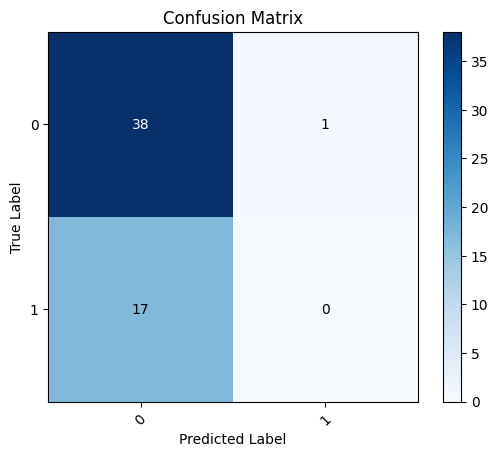

              precision    recall  f1-score   support

           0       0.69      0.97      0.81        39
           1       0.00      0.00      0.00        17

    accuracy                           0.68        56
   macro avg       0.35      0.49      0.40        56
weighted avg       0.48      0.68      0.56        56



In [22]:
label_file = test_label_file
true = label_file.to_numpy()[:, 2].flatten().tolist()
predicted = (np.array(test_preds) > 0.5).astype(np.int32).flatten().tolist()



true_labels = true
predicted_labels = predicted

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def create_confusion_matrix(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, f1

conf_matrix = create_confusion_matrix(true_labels, predicted_labels)
classes = ['0', '1']

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes)

# Calculate precision, recall, and F1-score

# Calculate precision, recall, and F1-score for both classes
classification_report = classification_report(true_labels, predicted_labels, target_names=classes)

print(classification_report)